### 0. Import libraries & functions

In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0";
#from pudb import set_trace
import numpy as np
import torch
from torchvision import models

import torch.backends.cudnn as cudnn
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from xmodels import *
from utils_se import *

from pointwise_attack import PointWiseAtt
from spaevo_attack import SpaEvoAtt
import pgd_attacks_pt2

In [2]:
def imshow(img):
    
    npimg = img[0].cpu().numpy()
    npimg = np.transpose(npimg,(1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.show()

In [3]:
def perturbation_heat_map(xo,xa):
    
    fig_dims = (5, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    x=torch.abs(xo-xa).sum(dim=1).cpu()[0]
    sns.heatmap(x,ax=ax,xticklabels=False, yticklabels=False,cbar = False)
    plt.show()

### 1. Load data, pretrained model, evaluation set

In [4]:
# a. Load dataset
batch_size = 1
dataset = 'cifar10' # or 'imagenet'
datapath = '../datasets/cifar10'#'../datasets/ImageNet-val'
testloader, testset = load_data(dataset,data_path=datapath,batch_size=batch_size)

Files already downloaded and verified


In [5]:
# b. Load pre-trained model

# 'resnet50' if pre-trained model from Pytorch. 'resnet18' if using pre-trained cifar10 model
arch = 'resnet18' 

# None means using pre-traineded model from Pytorch or default path. Otherwise, please change model_path = '...'
model_path = None 

# True means pre-trained model does "not" normalized data while training, 
# so no need to unnorm during intergerence (used for CIFAR10 model)

if dataset == 'cifar10':
    num_classes = 10
    norm = False # True means pre-trained model does "not" normalized data while training.
    
elif dataset == 'imagenet':
    num_classes = 1000
    norm = False # True means pre-trained model does "not" normalized data while training.

net = load_model(arch,model_path)
model = PretrainedModel(net,dataset,arch,norm)

In [6]:
def test(model):
    print('\n[ Test Start ]')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    benign_correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)

            outputs = model.predict_label(inputs)
            if outputs==targets:
                benign_correct += 1

            if batch_idx % 2000 == 0:
                print('Current batch:', str(batch_idx),
                      'Current benign test accuracy:', str(benign_correct/ total))

    print('\nTotal benign test accuarcy:', 100. * benign_correct / total)

In [14]:
test(model)


[ Test Start ]
Current batch: 0 Current benign test accuracy: 1.0
Current batch: 2000 Current benign test accuracy: 0.952023988005997
Current batch: 4000 Current benign test accuracy: 0.950012496875781
Current batch: 6000 Current benign test accuracy: 0.9528411931344776
Current batch: 8000 Current benign test accuracy: 0.952880889888764

Total benign test accuarcy: 95.37


In [6]:
# c. Load evaluation set
targeted = True # True means targeted attack. False means untargeted attack.
seed = 999

ID_set = get_evalset(model,dataset,arch,testset,seed,targeted)

### 2. PointWise Evaluation

In [7]:
i = 31#114
o = ID_set[i,1] #oID
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()
query_limit = 2000
nquery = 0
n_pix = 4
seed = 0

if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    timg, tlabel = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
else: 
    init_mode = 'salt_pepper_att' 
    timg, nqry,_ = gen_starting_point(model,oimg,olabel,seed,dataset,init_mode)
    tlabel = None
    nquery += nqry

attack = PointWiseAtt(model,flag=targeted)

#adv, nqry, Dt = attack.pw_perturb(oimg.cpu().numpy(),timg.cpu().numpy(),olabel,tlabel,max_query=query_limit)
adv, nqry, Dt = attack.pw_perturb_multiple(oimg.cpu().numpy(),timg.cpu().numpy(),olabel,tlabel,n_pix,max_query=query_limit)
    
adv = torch.from_numpy(adv.reshape(oimg.shape)).cuda()

nqry = 400; Reset value to original -> new distance: 11.239893913269043; L0 = 947; pred label: tensor([5], device='cuda:0')
nqry = 600; Reset value to original -> new distance: 9.634395599365234; L0 = 782; pred label: tensor([5], device='cuda:0')
refine stage!
nquery = 1000; Set value at 88 from [0.8352941  0.5568628  0.91764706 0.8862745 ] to [0.8352941 0.5568628 0.8827512 0.8862745] (original has [0.8352941 0.5568628 0.654902  0.8862745]) -> new distance: 7.551494598388672; 
pred label:tensor([5], device='cuda:0'); L0:465
nquery = 1200; Set value at 167 from [0.76862746 0.73333335 0.50980395 0.7882353 ] to [0.76862746 0.73333335 0.50980395 0.786466  ] (original has [0.76862746 0.73333335 0.50980395 0.7647059 ]) -> new distance: 7.122283935546875; 
pred label:tensor([5], device='cuda:0'); L0:435
nquery = 1600; Set value at 258 from [0.827451   0.8        0.39215687 0.84705883] to [0.827451   0.8        0.39178157 0.84705883] (original has [0.827451   0.8        0.2        0.84705883])

Source image:


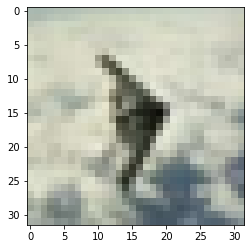

Starting image:


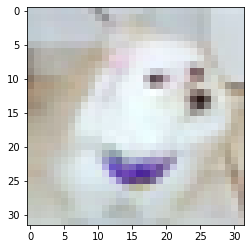

Adversarial Example:


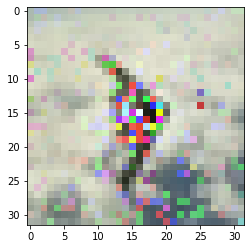

Perturbation Heat Map:


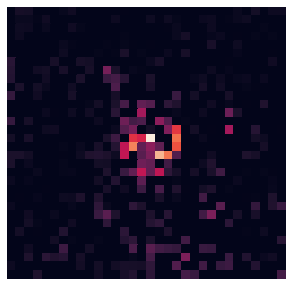

In [8]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [9]:
DPw = Dt

In [10]:
# check prediction of adversarial example
alabel = model.predict_label(adv).item()
dist = l0b(oimg,adv)#DPw[-1]
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L0 dist:{dist}')

- sample ID: 5013
- ground-truth: 0 
- target label: 5 
- AdvEx label: 5
- L0 dist:355


### 3. PGD_L0 Evaluation

In [11]:
if dataset == 'imagenet':
    mu = (0.0, 0.0, 0.0)
    std = (1.0, 1.0, 1.0)

    if targeted:
        num_steps = 5000
        step_size = 224*224*3*(0.025)
        LB_L0 = 0
        UB_L0 = 4000
    else:
        num_steps = 2000
        step_size = 224*224*3*(0.05)
        LB_L0 = 0
        UB_L0 = 800

elif dataset == 'cifar10':
    mu = (0.0, 0.0, 0.0)
    std = (1.0, 1.0, 1.0)

    if targeted:
        num_steps = 250
        step_size = 120000.0/255.0
        LB_L0 = 0
        UB_L0 = 200
    else:
        num_steps = 100
        step_size = 120000.0/255.0
        LB_L0 = 0
        UB_L0 = 100

pgd_args = {'type_attack': 'L0',
            'n_restarts': 1,
            'num_steps': num_steps,
            'step_size': step_size,
            'epsilon': -1,
            'sparsity': 100,
            'mu': mu,
            'std':std}

i = 31
o = ID_set[i,1] #oID
img, label = testset[o]
img = torch.unsqueeze(img, 0).cuda()
oimg = img.permute(0,2,3,1) # equal to np.transpose(img,(0,2, 3, 1))
olabel = np.expand_dims(label,axis = 0)

In [12]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

ub = UB_L0
lb = LB_L0  

while (ub - lb) > 5:
    k = int((ub + lb)//2)
       
    # 2. Run attack
    # not "net" but "model" instead because the net is drafted in PreTrainedModel 
    # and mu,std are feeded to pgd.attack with 0 & 1 since input is transformered PreTrainModel
    pgd_args['sparsity'] = k
    attack = pgd_attacks_pt2.PGDattack(model, pgd_args) 

    if targeted:
        label = np.expand_dims(ID_set[i,2].cpu().numpy(),axis=0) #tcla
        tlabel = label.item()
        adv, pgd_adv_acc, pixel_changed = attack.perturb_norm_target(oimg.cpu().numpy(), label)
    else: #untaget
        label = olabel
        adv, pgd_adv_acc, pixel_changed = attack.perturb_norm(oimg.cpu().numpy(), label)
                
    adv = torch.from_numpy(adv).cuda()
    adv = adv.permute(0,3,1,2)
    alabel = model.predict_label(adv)
    if alabel.cpu().numpy()!=olabel.item():
        ub = k
        L0 = pixel_changed.item()
        alabel_fin = alabel.item()
        adv_fin = adv.clone()
        print(olabel,alabel_fin,L0,k)
    else:
        lb = k

[0] 5 100 100
[0] 5 50 50
[0] 5 25 25
[0] 5 12 12
[0] 5 6 6
[0] 5 3 3


Source image:


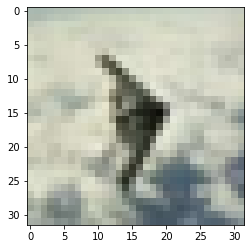

Adversarial Example:


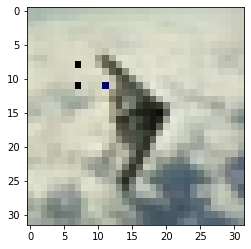

Perturbation Heat Map:


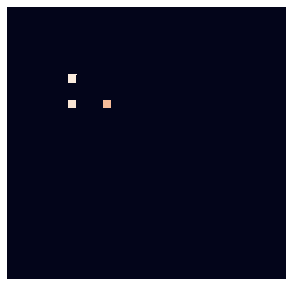

In [13]:
print('Source image:')
imshow(img)

print('Adversarial Example:')
imshow(adv_fin)

print('Perturbation Heat Map:')
perturbation_heat_map(img,adv_fin)

### 4. RamBoAttack Evaluation

In [14]:
if dataset == 'cifar10':
    n_pix = 4 # 4, 16, 64, 256 only required for uni_rand: 4/(32*32) = 196/(224*224) = 0.004
    if targeted:
        mu = 0.01
    else:
        mu = 0.04
elif dataset == 'imagenet':
    n_pix = 196 # 49, 196, 784, 3136 only required for uni_rand: 4/(32*32) = 196/(224*224) = 0.004
    if targeted:
        mu = 0.001
    else:
        mu = 0.004

query_limit = 2000
nquery = 0
pop_size = 10
cr = 0.5
seed = 0
n = n_pix

attack = SpaEvoAtt(model,n,pop_size,cr,mu,seed,flag=targeted)

In [15]:
# change i to select sample from selected (generated) evaluation set
i = 31# 115,51,113,999,12,123,114,123
o = ID_set[i,1] #oID
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    timg, tlabel = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
else:
    init_mode = 'salt_pepper_att' #'gauss_rand' #'salt_pepper'
    timg, nqry,_ = gen_starting_point(model,oimg,olabel,seed,dataset,init_mode)
    tlabel = None
    nquery += nqry
    
adv, nqry,Dt = attack.evo_perturb(oimg,timg,olabel,tlabel,max_query=query_limit)

DSpaEvo = Dt

Source image:


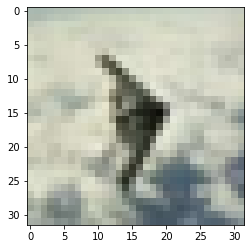

Starting image:


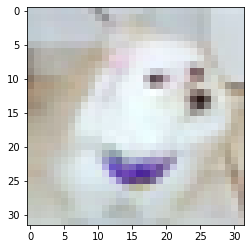

Adversarial Example:


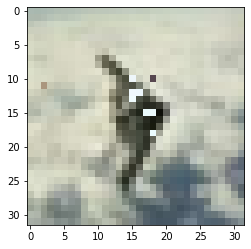

Perturbation Heat Map:


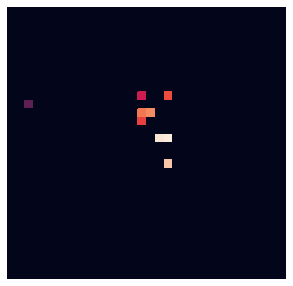

In [16]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [17]:
# check prediction of adversarial example
alabel = model.predict_label(adv).item()
dist = l0b(oimg,adv)#DSpaEvo[-1]
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L0 dist:{dist}')

- sample ID: 5013
- ground-truth: 0 
- target label: 5 
- AdvEx label: 5
- L0 dist:9


### 6. Plot Distortion vs Queries

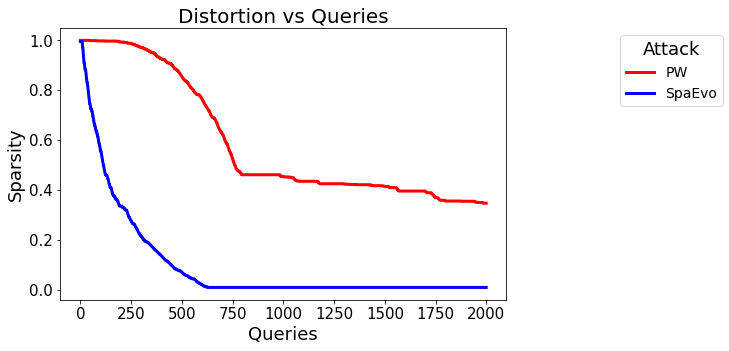

In [18]:
img_size = 32*32
nq = query_limit
q = np.arange(nq)
df = pd.DataFrame({'qry':q,'dPW':DPw[:nq]/img_size,
                   'dSpaE':DSpaEvo[:nq].cpu().numpy()/img_size})

fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
f = sns.lineplot(x = 'qry', y = 'dPW',ax=ax,linewidth = 3, color = 'red',label = 'PW',data=df)
f = sns.lineplot(x = 'qry', y = 'dSpaE',ax=ax,linewidth = 3, color = 'blue',label = 'SpaEvo',data=df)

f.axes.set_title("Distortion vs Queries",fontsize=20)
f.set_xlabel("Queries",fontsize=18)
f.set_ylabel("Sparsity",fontsize=18)
f.tick_params(labelsize=15)
#plt.legend(labels=['RamBoAttack (HSJA)'])
plt.legend(title='Attack', fontsize='14', title_fontsize='18',bbox_to_anchor= (1.5,1))
plt.show()